GitHub repository: [recommendation_system_service](https://github.com/GitHub-User228/recommendation_system_service)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

warnings.filterwarnings("ignore")

import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set_style("dark")
sns.set_theme(style="darkgrid", palette="deep")

from scripts.utils import get_runs_data, read_yaml
from scripts.components.preprocessing import PreprocessingComponent
from scripts.components.eda import EDAComponent
from scripts.components.features_generator import FeaturesGeneratorComponent
from scripts.components.matrix_builder import MatrixBuilderComponent
from scripts.components.als import ALSModelComponent
from scripts.components.bpr import BPRModelComponent
from scripts.components.item2item import Item2ItemModelComponent
from scripts.components.top_items import TopItemsModelComponent
from scripts.components.ensemble import EnsembleModelComponent

2024-11-10 07:49:22,610 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/config/components.yaml has been loaded


# <p style="color: #33FF33; text-align:center;"> STAGE I. Data preprocessing</p>

## <p style="color: #999900;"> 1. Preparations </p>

This section must be done separately
(so the jupyter session must be restarted after execution)

The code below casts `started_at`'s type from `datetime` to `date` using `pyarrow`.
This is necessary because otherwise `pyspark` will not be able to read the corresponding dataframe

In [3]:
# import pyarrow as pa
# import pyarrow.compute as pc

# df = pq.read_table(Path(env_vars.artifacts_dir, 'interactions_old.parquet'))
# df = df.drop_columns('__index_level_0__')

# date_column = pc.cast(df['started_at'], pa.date32())

# df = df.set_column(
#     df.schema.get_field_index('started_at'),
#     'started_at',
#     date_column
# )

# pq.write_table(df, Path(env_vars.artifacts_dir, 'interactions.parquet'))

## <p style="color: #999900;"> 2. Data preprocessing </p>

In [4]:
preprocessor = PreprocessingComponent(print_info=True)

2024-11-10 07:49:23,134 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/config/spark_config.yaml has been loaded


24/11/10 07:49:25 WARN Utils: Your hostname, epd8p8viml4bs7ctd2uc resolves to a loopback address: 127.0.1.1; using 10.129.0.85 instead (on interface eth0)
24/11/10 07:49:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/10 07:49:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### <p style="color: #FFB266;"> 2.1. catalog_names </p>

In [6]:
preprocessor.preprocess_catalog_names()

2024-11-09 16:04:03,134 [recsys_experiments] [read_parquet] - INFO: Read catalog_names.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts.
----- catalog_names dataframe info -----

-- info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      uint32
 1   type    object
 2   name    object
dtypes: object(2), uint32(1)
memory usage: 34.6+ MB
None

-- sample --
|    |   id | type   | name              |
|---:|-----:|:-------|:------------------|
|  0 |    3 | album  | Taller Children   |
|  1 |   12 | album  | Wild Young Hearts |
|  2 |   13 | album  | Lonesome Crow     |
|  3 |   17 | album  | Graffiti Soul     |
|  4 |   26 | album  | Blues Six Pack    |

-- missing data count --
|      |   0 |
|:-----|----:|
| id   |   0 |
| type |   0 |
| name |   0 |

-- duplicates count --
along ('id', 'type'): 0 (0.0%)
along "name" for "type" al

Speaking about `catalog_names` dataframe:

- There are no missing data.
- There are 1000000 `tracks`
- There are duplicates in the `name` feature for some `type`s.  
Since we only kwow the `name` feature which describes each group, it is not a good idea   
to just drop the duplicates or recode the `id` column - we might lose potentially essential   
information (e.g. one `album` has a lot of `tracks` in it, while another has almost `no tracks` though the `album_name` is the same)
- There are several groups with the `None-like` values in the names.  
It might seem better to replace them with a missing value, however we might also lose information  
after that - it is possible that some `album`s, `track`s or `artist`s have `'None'` name for some reason.  
Therefore, such values will be kept as they are
- Speaking of the performance, it is better to split the dataframe by `type`

Speaking about `IDs` in dataframes with `names`:
- the ids have to be changed, so that they all start at 0 and end at the number of unique ids - 1.  
  This will not be done at this moment, but left for the future stages.

### <p style="color: #FFB266;"> 2.2. tracks </p>

In [7]:
preprocessor.preprocess_tracks()

2024-11-09 16:04:29,618 [recsys_experiments] [read_parquet] - INFO: Read tracks.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts.
----- 'tracks' dataframe info -----

-- info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  uint32
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: object(3), uint32(1)
memory usage: 26.7+ MB
None

-- sample --
   track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 249080

About `tracks` dataframe:
- There are no duplicates or missing data
- There is the same amount of tracks as in the `catalog_names` dataframe. This means that all `tracks` have a name (if to check IDs directly, the subsets will be the same)
- It is better to `"explode"` other columns since they conist of lists - it will be much better later to deal with data in this format.

About `track_album`, `track_artist` and `track_genre` dataframes:
- There are no duplicates
- There are very few tracks with no data for some features

### <p style="color: #FFB266;"> 2.3. interactions </p>

In [5]:
preprocessor.preprocess_interactions()

2024-11-10 07:49:32,140 [recsys_experiments] [read_parquet] - INFO: Read interactions.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts.


2024-11-10 07:50:38,301 [recsys_experiments] [save_parquet] - INFO: Saved events_train.parquet to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.


2024-11-10 07:50:46,856 [recsys_experiments] [save_parquet] - INFO: Saved events_target.parquet to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.


2024-11-10 07:50:55,103 [recsys_experiments] [save_parquet] - INFO: Saved events_test.parquet to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.



----- 'interactions' dataframe info -----

-- schema --
root
 |-- user_id: integer (nullable = true)
 |-- track_id: integer (nullable = true)
 |-- track_seq: short (nullable = true)
 |-- started_at: date (nullable = true)

-- sample --
+-------+--------+---------+----------+
|user_id|track_id|track_seq|started_at|
+-------+--------+---------+----------+
|      0|   99262|        1|2022-07-17|
|      0|  589498|        2|2022-07-19|
|      0|  590262|        3|2022-07-21|
|      0|  590303|        4|2022-07-22|
|      0|  590692|        5|2022-07-22|
+-------+--------+---------+----------+
only showing top 5 rows

-- missing data count --


+-------+--------+---------+----------+
|user_id|track_id|track_seq|started_at|
+-------+--------+---------+----------+
|      0|       0|        0|         0|
+-------+--------+---------+----------+



Number of:  events - 222629898, users - 1373221 items - 1000000 sparsity - 99.9838%

----- 'events_train' dataframe info -----


Number of: events - 208731252 (93.76%), users - 1342566 (97.77%) items - 999695 (99.97%)
 sparsity - 99.9844%

----- 'events_test' dataframe info -----


Number of: events - 13898646 (6.24%), users - 783525 (57.06%),  items - 594326 (59.43%),  sparsity - 99.997%
 users (test only) - 783525 (2.23%)



It can be seen that:
- There are no missing data
- There is the same amount of tracks as in the `catalog_names` dataframe. This means that all `tracks` have been listened to at least a single time (if to check IDs directly, the subsets will be the same)
- There are also no duplicates since each `interaction` `(event)` is denoted as a first `interaction` between `user` and `track`
- There are:
    - total: 1373221 `users`, 1000000 `items`, 222629898 `events`, 99.9838% `sparsity`
    - train: 97.77% `users`, 99.97% `items`, 93.76% `events`, 99.9844% `sparsity`
    - test: 57.06% `users`, 59.43% `items`, 6.24% `events`, 99.9970% `sparsity`
    - test only: 2.23% `users`  
    
Unsuprisingly, there are some new `users` in the test set. These `users` can't be used when building any recommendation model apart from the simplest one, which recommends the most popular `tracks`

The test set was further splited into target and test subsets.
    
Since the sparsity is huge, it is a good idea to check if there are any `tracks` with very low number of `events` - those `tracks` can be considered as a noise and omitted when building a recommendation model.

## <p style="color: #999900;"> 3. Conclusions </p>

1. No missing data was observed apart from very few tracks with no data for some track features
2. There are no `tracks` with 0 playbacks
3. No duplicates were observed apart from duplicated `name` field for some `tracks`, `albums` and `artists`.
    Those `name`s were not reindexed since this action might lead to information loss
4. About 2% of the test users are new - they will not be considered when building recommendation models 
5. It is a good idea to omit the least popular `tracks` - it might improve the quality of the recommendations

## <p style="color: #999900;"> 4. Logging </p>

In [9]:
preprocessor.log()

2024-11-09 16:23:37,553 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists


2024/11/09 16:23:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run preprocessing at: http://127.0.0.1:5000/#/experiments/15/runs/2823a2df7dab4c828f0c398b8a17a520.
2024/11/09 16:23:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

: 

# <p style="color: #33FF33; text-align:center;"> STAGE II. EDA</p>

<p style="color: #FF0000; font-size:24px;"> Restart the notebook before proceeding </p>

In [3]:
component = EDAComponent()

2024-11-09 16:24:29,759 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/config/spark_config.yaml has been loaded


24/11/09 16:24:31 WARN Utils: Your hostname, epd8p8viml4bs7ctd2uc resolves to a loopback address: 127.0.1.1; using 10.129.0.85 instead (on interface eth0)
24/11/09 16:24:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/09 16:24:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## <p style="color: #999900;"> 1. User-related analysis </p>

2024-11-09 16:24:36,331 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.
----- ITEMS PER USER -----




Most active users
|   user_id |   items_per_user |
|----------:|-----------------:|
|    398979 |            15955 |
|   1200889 |            14747 |
|    590868 |            14459 |
|    731216 |            12665 |
|    339714 |            12223 |
|   1288206 |            12016 |
|    474845 |            11925 |
|   1195393 |            11458 |
|    805623 |            10658 |
|   1195189 |            10542 |

Least active users
|   user_id |   items_per_user |
|----------:|-----------------:|
|    162328 |                1 |
|    173505 |                1 |
|    173142 |                1 |
|    169101 |                1 |
|   1040281 |                1 |
|   1036904 |                1 |
|   1047850 |                1 |
|   1049652 |                1 |
|    163247 |                1 |
|    158960 |                1 |

Number of unique users: 1342566


Quantiles
|    |   quantiles |   items_per_user |
|---:|------------:|-----------------:|
|  0 |       0.1   |               12 |
|  1 

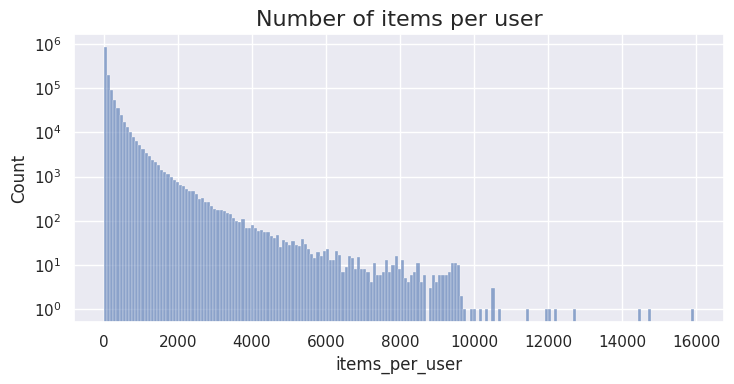

2024-11-09 16:24:55,196 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/items_per_user_hist.png


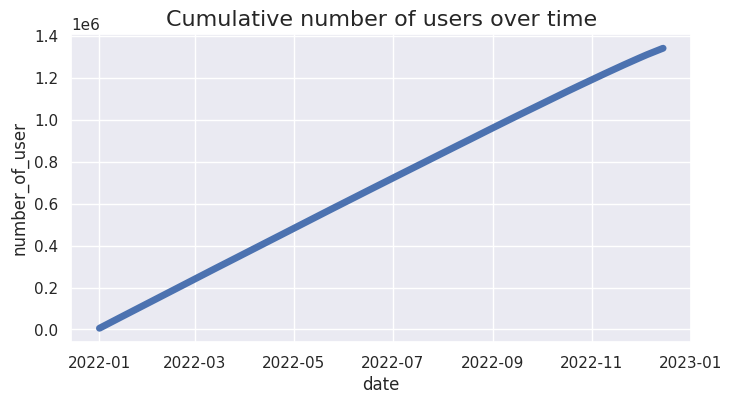

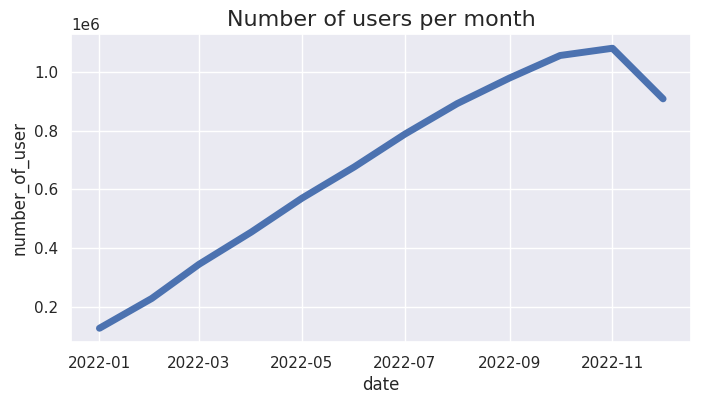

2024-11-09 16:26:16,330 [recsys_experiments] [user_analysis] - INFO: Finished user analysis


In [4]:
component.user_analysis()

1. Top users according to the activity (new tracks experience) lie far from the rest users according to the hist plot
2. Top 10 users listened to at least 10k different tracks
3. Least active users listened to only 1 track
4. The number of users with a specific activity rapidly declines as the activity grows
5. The cumulative number of users (i.e. the number of unique users up to specific date) increases linearly over time
6. The number of users per month (i.e. the number of unique users that have some activity in specific month) increases linearly over time, but a decline can be observed at the last month - probably most of the users have collected their corresponding set of tracks and almost stopped trying to search for new ones.

## <p style="color: #999900;"> 2. Track-related analysis </p>

2024-11-09 16:28:00,968 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.
----- USERS PER ITEM -----




Most popular items
|         |   users_per_item | track                   |
|--------:|-----------------:|:------------------------|
|  821569 |           110026 | Smells Like Teen Spirit |
| 1296347 |           101076 | Believer                |
|  839136 |           100866 | Numb                    |
| 1324628 |            95523 | I Got Love              |
| 1180543 |            84153 | Way Down We Go          |
|  902932 |            83749 | Shape Of My Heart       |
| 1009736 |            80608 | Seven Nation Army       |
| 1287760 |            80243 | Shape of You            |
|  819029 |            79512 | Zombie                  |
| 1459708 |            78564 | Life                    |

Least popular items
|         |   users_per_item | track                       |
|--------:|-----------------:|:----------------------------|
| 1800539 |                1 | Aus und Vorbei              |
| 1782031 |                1 | Fragments of Your Love      |
| 1231700 |                1 | K

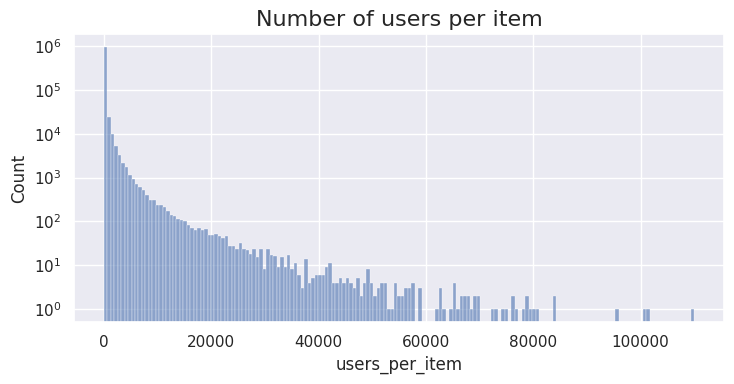

2024-11-09 16:28:21,470 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/users_per_item_hist.png


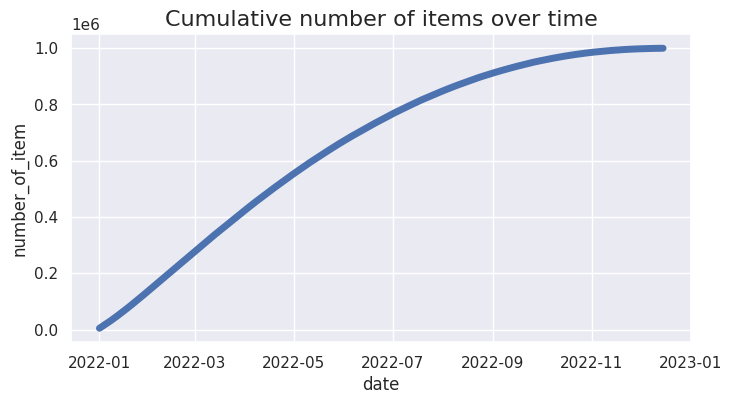

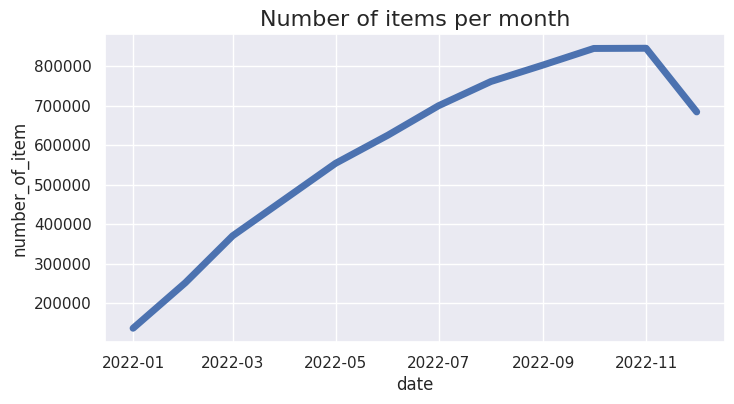

2024-11-09 16:30:13,332 [recsys_experiments] [item_analysis] - INFO: Finished item analysis


In [5]:
component.item_analysis()

1. The more popular the track the lower the number of them
2. Top tracks differ from the rest of the tracks significantly
3. Top tracks seem to be the ones that have to be popular
4. Top 10 tracks have at least 78k users that have listened to the track
5. Only a single user listened to the Least popular tracks
6. 90% of tracks have less than 300 playbacks
7. The cumulative number of tracks increases linearly over time and converges at the last observed month
8. The number of tracks per month (i.e. the number of tracks that were played by some user for the first time) increases linearly over time and declines at the last observed months

All in all, it might be beneficial to consider tracks with at least some popularity, so that too noisy tracks with no popularity are not included in the recommendation models. As a result, the offline recommendations will be more accurate, although at the cost of item coverage and also user coverage since omitting tracks leads to omitting certain amount of users that have only listened to those tracks.

## <p style="color: #999900;"> 3. Genre-related analysis </p>

2024-11-09 16:30:27,603 [recsys_experiments] [read_parquet] - INFO: Read track_genres.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.
----- GENRES PER ITEM -----

|   track_id |   genre_count | track                    |
|-----------:|--------------:|:-------------------------|
|    4984867 |            10 | Black Coffee             |
|    4984786 |            10 | Early in the Mornin'     |
|    4984839 |            10 | Feelin' Sad              |
|    4984834 |            10 | Georgia on My Mind       |
|    4984794 |            10 | Hallelujah I Love Her So |
|   22385046 |            10 | House Daddy              |
|    4984783 |            10 | My Melancholy Baby       |
|    4984825 |            10 | The Midnight Hour        |
|    4984869 |            10 | The Ray                  |
|    4984847 |            10 | You Won't Let Me Go      |

Quantiles
|    |   quantiles |   genre_count |
|---:|------------:|-------------

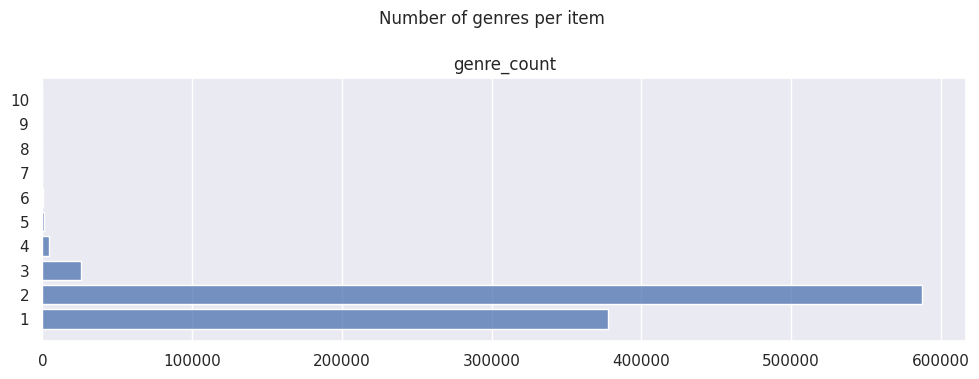

2024-11-09 16:30:29,786 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/genres_per_item_hist.png
----- ITEMS PER GENRE -----

Number of unique genres: 173

Most broad genres
|   genre_id |   item_count | genre       |
|-----------:|-------------:|:------------|
|         11 |       166285 | pop         |
|         75 |       128212 | rap         |
|        102 |       118509 | allrock     |
|         68 |       114245 | electronics |
|         47 |        72311 | metal       |
|          3 |        65958 | rusrap      |
|         44 |        59778 | foreignrap  |
|         14 |        55177 | rock        |
|         16 |        51631 | dance       |
|         20 |        46707 | ruspop      |

Least broad genres
|   genre_id |   item_count | genre            |
|-----------:|-------------:|:-----------------|
|         66 |           32 | israelirap       |
|   

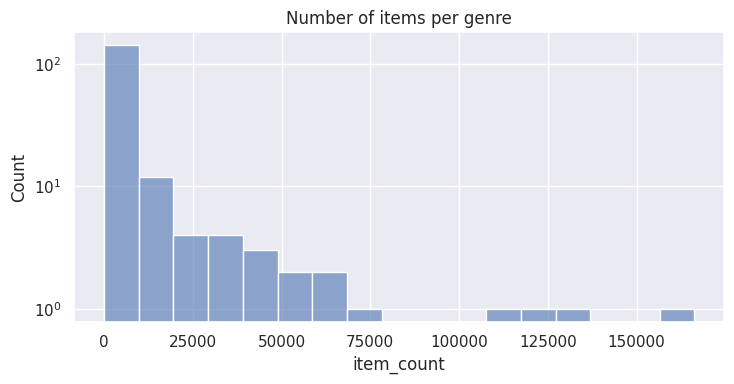

2024-11-09 16:30:30,425 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/items_per_genre_hist.png
2024-11-09 16:30:30,426 [recsys_experiments] [category_analysis] - INFO: Finished genre analysis


In [6]:
component.category_analysis('genre', yscale='log')

1. There are 173 genres
2. The majority of the tracks have either 1 or 2 specified genres
3. It is possible to find tracks with 10 specified genres, but there are very few of them
4. The broader the genre in terms of the corresponding tracks, the less the number of them
5. The broadest genres are indeed the ones that are the most popular
6. Top 10 genres have at least 45k tracks of the genre

## <p style="color: #999900;"> 4. Album-related analysis </p>

2024-11-09 16:33:56,966 [recsys_experiments] [read_parquet] - INFO: Read track_albums.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.
----- ALBUMS PER ITEM -----

|   track_id |   album_count | track                |
|-----------:|--------------:|:---------------------|
|   23233264 |          2844 | Liquid               |
|   24642198 |          2843 | One by One           |
|   23233263 |          2837 | Drifting             |
|   24269035 |          2827 | Out of the Blue 2015 |
|   24006507 |          2824 | Lamentation          |
|   24006508 |          2820 | For Keeps            |
|   23843412 |          2817 | Black Orpheus        |
|   24178049 |          2817 | Vault                |
|   23227138 |          2809 | Wave                 |
|   24178050 |          2807 | Start Tonight        |

Quantiles
|    |   quantiles |   album_count |
|---:|------------:|--------------:|
|  0 |       0.1   |             1 |
|  1 | 

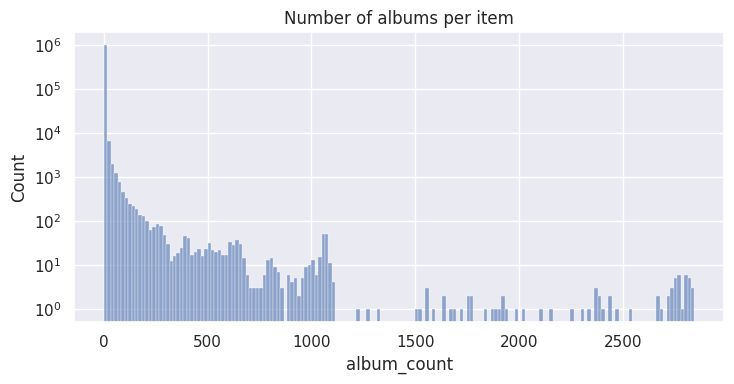

2024-11-09 16:34:00,060 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/albums_per_item_hist.png
----- ITEMS PER ALBUM -----

Number of unique albums: 658724

Most broad albums
|   album_id |   item_count | album                                 |
|-----------:|-------------:|:--------------------------------------|
|    7293229 |         1001 | Daily Easy English Expression Podcast |
|    6271311 |          880 | «Подкаст Лайфхакера»                  |
|    7121797 |          368 | Виват, история!                       |
|    6966125 |          348 | Брендятина                            |
|    6316997 |          334 | Newочём                               |
|   16272876 |          289 | 24 Hours Of R&B                       |
|    9091882 |          282 | ТЕД на русском                        |
|    6408431 |          260 | The Big Beard Theory                

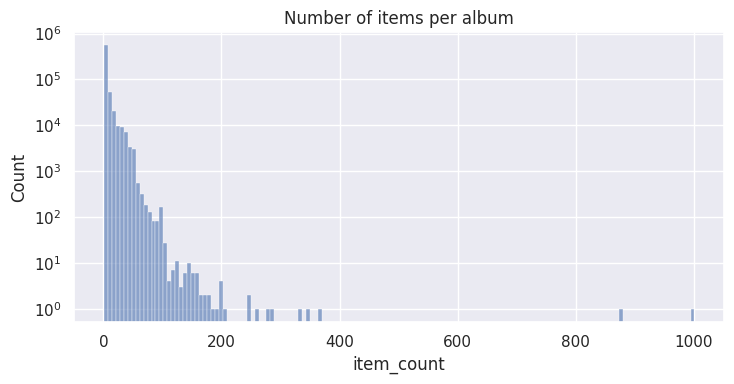

2024-11-09 16:34:02,581 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/items_per_album_hist.png
2024-11-09 16:34:02,582 [recsys_experiments] [category_analysis] - INFO: Finished album analysis


In [7]:
component.category_analysis('album', yscale='log')

1. There are 658724 albums
2. 99 % of tracks have at most about 25 specified albums
3. The broader the album, the less the number of them
4. 50% of albums have only a single track, while 99 % of albums have at most about 45 tracks
5. There are very few albums with at least 200 tracks - the corresponding tracks are usually related to some podcasts or tv shows tapes

## <p style="color: #999900;"> 5. Artist-related analysis </p>

2024-11-09 16:34:07,533 [recsys_experiments] [read_parquet] - INFO: Read track_artists.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.
----- ARTISTS PER ITEM -----

|   track_id |   artist_count | track                                                                                   |
|-----------:|---------------:|:----------------------------------------------------------------------------------------|
|   32192493 |             26 | #ЖИТЬ                                                                                   |
|   42952658 |             26 | #Жить                                                                                   |
|   53500595 |             16 | Les portes du pénitencier, Medine, Orelsan, Gringe, Vincenzo, Soprano & Alonzo (Psy 4)) |
|   24982259 |             16 | Love Song to the Earth                                                                  |
|   25736095 |             16 | Love Song t

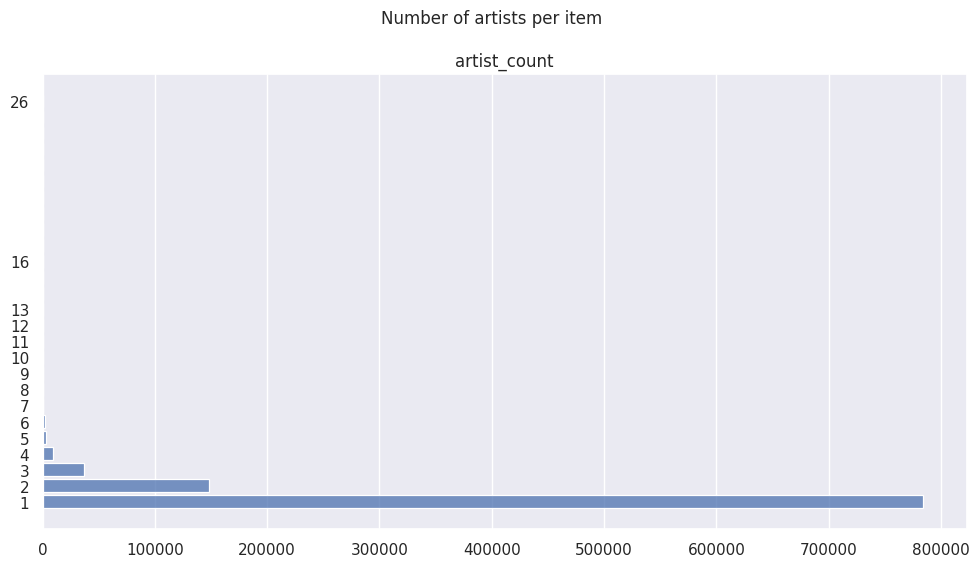

2024-11-09 16:34:09,640 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/artists_per_item_hist.png
----- ITEMS PER ARTIST -----

Number of unique artists: 153581

Most broad artists
|   artist_id |   item_count | artist                    |
|------------:|-------------:|:--------------------------|
|      118708 |         2038 | Владимир Высоцкий         |
|         171 |         1378 | сборник                   |
|      139896 |         1273 | Armin van Buuren          |
|        9170 |         1221 | Wolfgang  Amadeus Mozart  |
|        1227 |         1130 | Johann  Sebastian  Bach   |
|       11818 |         1058 | Hans Zimmer               |
|        1551 |         1043 | Pyotr Ilyich  Tchaikovsky |
|        3989 |         1021 | Frank Sinatra             |
|       10987 |          975 | Elvis Presley             |
|      188963 |          966 | Аквариум    

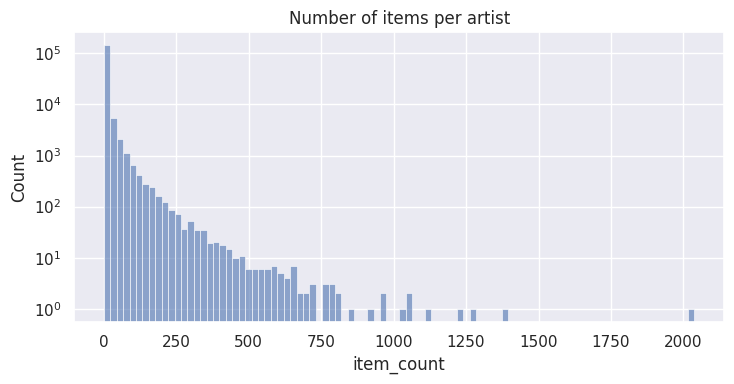

2024-11-09 16:34:10,690 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/eda/assets/items_per_artist_hist.png
2024-11-09 16:34:10,690 [recsys_experiments] [category_analysis] - INFO: Finished artist analysis


In [8]:
component.category_analysis('artist', yscale='log')

1. There are 153581 artists
2. The most popular artists are indeed the ones that are popular in real life. Although, the term "artist" does not correspond to a person for given data - "artist" can refer to a group of people, or even to a album of some sort
3. 70% of tracks have only a single artist, while 99 % of tracks have at most 4 different artists
4. There are very few outlier tracks with more than 6 different artists specified.
5. The popular the artist, the lower the number of them
6. 50% of artists made only a single track, while 99 % of atists made at most about 120 tracks 
7. There are very few artists that made at least 750 tracks

## <p style="color: #999900;"> 6. Logging </p>

In [9]:
component.log()

2024-11-09 16:34:13,154 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists


2024/11/09 16:34:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run eda at: http://127.0.0.1:5000/#/experiments/15/runs/5436a7fa8c254721b2983eadbe7ef4a7.
2024/11/09 16:34:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

: 

# <p style="color: #33FF33; text-align:center;"> STAGE III. Data Preparation </p>

<p style="color: #FF0000; font-size:24px;"> Restart the notebook before proceeding </p>

It was shown that the sparsity is too high. Therefore, there are two ways to train a recommendation model:
- using `Spark`
- using `scipy sparse matrix`

It was tested that, the second way is much faster and consumes a lot less RAM. 

Therefore, it is necessary to build sparse matrices - for user-items data and item-features data

## <p style="color: #999900;"> 1. Encoding user ID and item ID </p>

This section is necessary in order to build a sparse matrix for user-items data.

The process is done iteratively over partitions, so that less RAM is consumed.

In [5]:
component = MatrixBuilderComponent(print_info=True)

In [4]:
component.fit_encoders()

Processing partitions: 100%|██████████| 8/8 [01:43<00:00, 12.88s/it]

2024-11-09 16:37:16,566 [recsys_experiments] [fit_encoders] - INFO: Processed all partitions
2024-11-09 16:37:16,730 [recsys_experiments] [fit_encoders] - INFO: Fitted an encoder for item ID
2024-11-09 16:37:16,739 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl


2024-11-09 16:37:16,826 [recsys_experiments] [fit_encoders] - INFO: Fitted an encoder for user ID
2024-11-09 16:37:16,837 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_user.pkl


## <p style="color: #999900;"> 2. Building item-features matrices </p>

A separate matrix is built for each item-feature (genre, artist, album) with the corresponding feature encoder

In [5]:
component.build_item_features_matrices()

2024-11-09 16:42:39,405 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded


Processing features:   0%|          | 0/3 [00:00<?, ?it/s]

2024-11-09 16:42:39,492 [recsys_experiments] [build_item_features_matrices] - INFO: Read item-album dataframe
2024-11-09 16:42:39,668 [recsys_experiments] [build_item_features_matrices] - INFO: Left with 3128460 (99.99%) training items
2024-11-09 16:42:40,025 [recsys_experiments] [build_item_features_matrices] - INFO: Fitted an encoder for feature 'album'
2024-11-09 16:42:40,029 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_album.pkl
2024-11-09 16:42:40,079 [recsys_experiments] [build_item_features_matrices] - INFO: Built item-album sparse matrix
2024-11-09 16:42:41,288 [recsys_experiments] [build_item_features_matrices] - INFO: item-album matrix info: number of items - 999695, number of features - 658561, number of data points - 3128460, sparsity - 99.9995%


Processing features:  33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

2024-11-09 16:42:41,346 [recsys_experiments] [build_item_features_matrices] - INFO: Read item-artist dataframe
2024-11-09 16:42:41,468 [recsys_experiments] [build_item_features_matrices] - INFO: Left with 1263808 (99.97%) training items
2024-11-09 16:42:41,664 [recsys_experiments] [build_item_features_matrices] - INFO: Fitted an encoder for feature 'artist'
2024-11-09 16:42:41,666 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_artist.pkl
2024-11-09 16:42:41,715 [recsys_experiments] [build_item_features_matrices] - INFO: Built item-artist sparse matrix
2024-11-09 16:42:42,580 [recsys_experiments] [build_item_features_matrices] - INFO: item-artist matrix info: number of items - 999695, number of features - 153549, number of data points - 1263808, sparsity - 99.9992%


Processing features:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

2024-11-09 16:42:42,637 [recsys_experiments] [build_item_features_matrices] - INFO: Read item-genre dataframe
2024-11-09 16:42:42,757 [recsys_experiments] [build_item_features_matrices] - INFO: Left with 1652175 (99.97%) training items
2024-11-09 16:42:43,025 [recsys_experiments] [build_item_features_matrices] - INFO: Fitted an encoder for feature 'genre'
2024-11-09 16:42:43,026 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_genre.pkl
2024-11-09 16:42:43,062 [recsys_experiments] [build_item_features_matrices] - INFO: Built item-genre sparse matrix
2024-11-09 16:42:43,651 [recsys_experiments] [build_item_features_matrices] - INFO: item-genre matrix info: number of items - 999695, number of features - 173, number of data points - 1652175, sparsity - 99.0447%


Processing features: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


It can be seen, that the sparsity rate is big for each matrix.

## <p style="color: #999900;"> 3. Building user-items matrix </p>

The matrix is filled in separately for each partition, so that less RAM is consumed.

In [6]:
component.build_user_items_matrix()

2024-11-09 17:00:24,818 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_user.pkl has been loaded
2024-11-09 17:00:24,824 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded
2024-11-09 17:00:24,825 [recsys_experiments] [build_user_items_matrix] - INFO: Initialized empty user-items sparse matrix


Processing partitions:   0%|          | 0/8 [00:00<?, ?it/s]

Processing partitions: 100%|██████████| 8/8 [01:21<00:00, 10.21s/it]

2024-11-09 17:01:46,474 [recsys_experiments] [build_user_items_matrix] - INFO: Build user-items sparse matrix


2024-11-09 17:02:33,450 [recsys_experiments] [build_user_items_matrix] - INFO: user-items matrix info: number of users - 1342566, number of items - 999695, number of events - 208731252, sparsity - 99.98%


Logging

In [7]:
component.log()

2024-11-09 17:03:13,335 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists


2024/11/09 17:03:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run matrices at: http://127.0.0.1:5000/#/experiments/15/runs/7bbc70d4ed38428d93c25cd2acf50cec.
2024/11/09 17:03:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

: 

## <p style="color: #999900;"> 4. Creating user and item features </p>

<p style="color: #FF0000; font-size:24px;"> Restart the notebook before proceeding </p>

Since a ranking model will be used over recommendation models, it might benefit from user and item features. Let's build most common ones using a separate component.

In [3]:
component = FeaturesGeneratorComponent()

2024-11-09 17:03:39,217 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/config/spark_config.yaml has been loaded


24/11/09 17:03:40 WARN Utils: Your hostname, epd8p8viml4bs7ctd2uc resolves to a loopback address: 127.0.1.1; using 10.129.0.85 instead (on interface eth0)
24/11/09 17:03:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/09 17:03:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
component.generate_item_features()

2024-11-09 17:03:47,942 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.


2024-11-09 17:04:39,975 [recsys_experiments] [save_parquet] - INFO: Saved item_features.parquet to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/features.
2024-11-09 17:04:39,977 [recsys_experiments] [generate_item_features] - INFO: Generated item features saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/features.


The following features were generated for `items`:
- `users_per_item`
- `users_per_item` since last 7 or 30 days
- the number of days since the first `interaction` for an `item`
- the number of days since the last `interaction` for an `item`


In [5]:
component.generate_user_features()

2024-11-09 17:04:40,090 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/preprocessing.


2024-11-09 17:05:02,621 [recsys_experiments] [save_parquet] - INFO: Saved user_features.parquet to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/features.
2024-11-09 17:05:02,622 [recsys_experiments] [generate_user_features] - INFO: Generated user features saved to /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/features.


The following features were generated for `users`:
- `items_per_user`
- `items_per_user` since last 7 or 30 days
- the number of days since the first `interaction` for a `user`
- the number of days since the last `interaction` for a `user`


ALthough it is possible to come up with more features, let's leave it as it is for now.

Logging

In [6]:
component.log()

2024-11-09 17:05:02,740 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists


2024/11/09 17:05:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run features_generation at: http://127.0.0.1:5000/#/experiments/15/runs/1652c16167de45ddb4cdc0be7b81ac07.
2024/11/09 17:05:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

: 

# <p style="color: #33FF33; text-align:center;"> STAGE IV. Modelling </p>

## <p style="color: #999900;"> 1. Base recommendation models </p>

The base recommendation models will be:
- ALS (Alternating Least Squares)
- BPR (Bayesian Personalized Ranking)
- Item2Item
- top N popular items (top N items with the highest number of interactions)

Item2Item model works with item-features matrix. Given a user ID and interactions history data (which items have been interacted with by a user), it computes an average item-features vector and then finds top items according to the similarity criteria. To speed up the computation, the following was used:
- TruncatedSVD algorithm - reduces the number of item features
- NearestNeighbors algorithm - a much faster computation of the closest item-features vectors for a given vector

Speaking of adding top N popular items, it is important to note that only new `(user, item)` pairs will be added to the data, so that the `Novelty` is equal to 1

As it was pointed out, it is essential to omit too unpopular items in order to improve the quality of the recommendations. The following cut-off values for the number of users per item will be used:
- ALS: 300
- BPR: 300
- Item2Item: 1000

### <p style="color: #999900;"> I. ALS model </p>

<p style="color: #FF0000; font-size:20px;"> Restart the notebook before proceeding </p>

In [4]:
model = ALSModelComponent()

In [4]:
model.fit()

2024-11-09 11:49:57,115 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded
2024-11-09 11:49:57,136 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/matrices/encoder_user.pkl has been loaded
2024-11-09 11:50:07 [ALS] [fit] - INFO: Left with 95665 (9.57%) popular items
2024-11-09 11:50:08 [ALS] [fit] - INFO: Left with 1334693 (99.41%) active users
2024-11-09 11:50:08 [ALS] [fit] - INFO: Fitted item_id encoder
2024-11-09 11:50:08 [ALS] [fit] - INFO: Fitted user_id encoder


100%|██████████| 15/15 [02:26<00:00,  9.77s/it, loss=0.00114]

2024-11-09 11:52:44 [ALS] [fit] - INFO: Fitted ALS model


2024-11-09 11:52:44,789 [recsys_experiments] [fit] - INFO: Trained ALS model
2024-11-09 11:52:46,408 [recsys_experiments] [fit] - INFO: Saved ALS model
2024-11-09 11:52:47 [ALS] [get_similar_items] - INFO: Generated similar items
2024-11-09 11:52:48 [ALS] [get_similar_items] - INFO: Prepared a dataframe with similar items
2024-11-09 11:52:48,181 [recsys_experiments] [fit] - INFO: Saved similar items data


In [6]:
model.recommend(subset='target')

2024-11-09 11:53:23,027 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-11-09 11:53:23,165 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'target'
2024-11-09 11:53:24,926 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/als/als.pkl has been loaded
2024-11-09 11:53:25 [ALS] [recommend] - INFO: Found 659193 (96.85%) users from 680623 in the model
2024-11-09 11:53:30 [ALS] [recommend] - INFO: Filtered user_items_matrix
2024-11-09 11:53:40 [ALS] [recommend] - INFO: Generated recommendations
2024-11-09 11:53:49 [ALS] [recommend] - INFO: Prepared a Dataframe with recommendations
2024-11-09 11:53:50,157 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'target'


In [8]:
model.recommend(subset='test')

2024-11-09 11:54:50,492 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-11-09 11:54:50,597 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'test'
2024-11-09 11:54:52,287 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/als/als.pkl has been loaded
2024-11-09 11:54:52 [ALS] [recommend] - INFO: Found 572152 (94.39%) users from 606174 in the model
2024-11-09 11:54:57 [ALS] [recommend] - INFO: Filtered user_items_matrix
2024-11-09 11:55:05 [ALS] [recommend] - INFO: Generated recommendations
2024-11-09 11:55:13 [ALS] [recommend] - INFO: Prepared a Dataframe with recommendations
2024-11-09 11:55:13,865 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'test'


In [6]:
model.evaluate()

Evaluating recommendations: 100%|██████████| 606174/606174 [00:45<00:00, 13203.66it/s]

2024-11-09 11:57:09,875 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision@10': 0.005764620763661154, 'Recall@10': 0.018210318408416085, 'NDCG@10': 0.012176213783975971, 'CoverageItem@10': 0.019404056183845875, 'CoverageUser@10': 0.9438742011369673}


2024-11-09 11:57:10,173 [recsys_experiments] [save_yaml] - INFO: YAML file /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/als/metrics.yaml has been written successfully.


In [5]:
model.log()

2024-11-09 17:06:06,656 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists
2024-11-09 17:06:12,663 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/als/metrics.yaml has been loaded


2024/11/09 17:06:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run base_model_als at: http://127.0.0.1:5000/#/experiments/15/runs/3f35d88219bd4ca99c262f82f4926db7.
2024/11/09 17:06:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

: 

### <p style="color: #999900;"> II. BPR model </p>

<p style="color: #FF0000; font-size:20px;"> Restart the notebook before proceeding </p>

In [3]:
model = BPRModelComponent()

In [6]:
model.fit()

2024-11-09 11:59:07,845 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded
2024-11-09 11:59:07,853 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/matrices/encoder_user.pkl has been loaded


2024-11-09 11:59:17 [BPR] [fit] - INFO: Filtered 95665 (9.57%) popular items
2024-11-09 11:59:18 [BPR] [fit] - INFO: Filtered 1334693 (99.41%) active users
2024-11-09 11:59:18 [BPR] [fit] - INFO: Fitted item_id encoder
2024-11-09 11:59:18 [BPR] [fit] - INFO: Fitted user_id encoder


100%|██████████| 50/50 [04:25<00:00,  5.30s/it, train_auc=96.44%, skipped=2.98%]

2024-11-09 12:03:47 [BPR] [fit] - INFO: Fitted BPR model
2024-11-09 12:03:47,601 [recsys_experiments] [fit] - INFO: Trained BPR model


2024-11-09 12:03:49,388 [recsys_experiments] [fit] - INFO: Saved BPR model
2024-11-09 12:03:52 [BPR] [get_similar_items] - INFO: Generated similar items
2024-11-09 12:03:53 [BPR] [get_similar_items] - INFO: Prepared a Dataframe with similar items
2024-11-09 12:03:53,010 [recsys_experiments] [fit] - INFO: Generated similar items
2024-11-09 12:03:53,135 [recsys_experiments] [fit] - INFO: Saved similar items data


In [7]:
model.recommend(subset='target')

2024-11-09 12:04:22,015 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-11-09 12:04:22,187 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'target'
2024-11-09 12:04:23,713 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/bpr/bpr.pkl has been loaded
2024-11-09 12:04:24 [BPR] [recommend] - INFO: Found 659193 (96.85%) users from 680623 in the model
2024-11-09 12:04:28 [BPR] [recommend] - INFO: Filtered user_items_matrix
2024-11-09 12:04:38 [BPR] [recommend] - INFO: Generated recommendations
2024-11-09 12:04:47 [BPR] [recommend] - INFO: Prepared a Dataframe with recommendations
2024-11-09 12:04:48,031 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'target'


In [8]:
model.recommend(subset='test')

2024-11-09 12:04:53,734 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-11-09 12:04:53,835 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'test'
2024-11-09 12:04:55,702 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/bpr/bpr.pkl has been loaded
2024-11-09 12:04:55 [BPR] [recommend] - INFO: Found 572152 (94.39%) users from 606174 in the model
2024-11-09 12:05:00 [BPR] [recommend] - INFO: Filtered user_items_matrix
2024-11-09 12:05:08 [BPR] [recommend] - INFO: Generated recommendations
2024-11-09 12:05:16 [BPR] [recommend] - INFO: Prepared a Dataframe with recommendations
2024-11-09 12:05:16,879 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'test'


In [9]:
model.evaluate()

Evaluating recommendations: 100%|██████████| 606174/606174 [00:43<00:00, 13947.88it/s]

2024-11-09 12:06:21,050 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision@10': 0.006119654128206073, 'Recall@10': 0.02109216769790034, 'NDCG@10': 0.014424761999565766, 'CoverageItem@10': 0.2000309209600266, 'CoverageUser@10': 0.9438742011369673}


2024-11-09 12:06:21,331 [recsys_experiments] [save_yaml] - INFO: YAML file /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/bpr/metrics.yaml has been written successfully.


In [4]:
model.log()

2024-11-09 17:06:27,554 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists
2024-11-09 17:06:33,170 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/bpr/metrics.yaml has been loaded


2024/11/09 17:06:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run base_model_bpr at: http://127.0.0.1:5000/#/experiments/15/runs/ab7b73e5aa6d41cb9f6ca59072bbc6c8.
2024/11/09 17:06:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

### <p style="color: #999900;"> III. Item2Item model </p>

<p style="color: #FF0000; font-size:20px;"> Restart the notebook before proceeding </p>

In [5]:
model = Item2ItemModelComponent()

In [ ]:
model.fit()

2024-11-04 17:35:28,242 [fastapi_project] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded
2024-11-04 17:35:28,249 [fastapi_project] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/matrices/encoder_user.pkl has been loaded
2024-11-04 17:35:35 [Item2ItemModel] [fit] - INFO: Filtered 37674 (3.77%) popular items
2024-11-04 17:35:35 [Item2ItemModel] [fit] - INFO: Filtered 81302 (10.01%) features with some data
2024-11-04 17:35:39 [Item2ItemModel] [fit] - INFO: Filtered 1327258 (98.86%) active users
2024-11-04 17:35:39 [Item2ItemModel] [fit] - INFO: Fitted item_id encoder
2024-11-04 17:35:39 [Item2ItemModel] [fit] - INFO: Fitted user_id encoder
2024-11-04 17:35:43 [Item2ItemModel] [fit] - INFO: Fitted TruncatedSVD model
2024-11-04 17:35:43 [Item2ItemModel] [fit] - INFO: Total Explained Variance: 0.3040
2024-11-04 17:35:43 [Item2ItemModel] [fit] - INFO: Fitted Neares

In [ ]:
model.recommend(subset='test')

2024-11-04 17:35:47,539 [fastapi_project] [recommend_for_subset] - INFO: User IDs have been retrieved for subset 'test'
2024-11-04 17:35:47,582 [fastapi_project] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/item2item/item2item.pkl has been loaded
2024-11-04 17:35:56 [Item2ItemModel] [recommend] - INFO: Found 568630 (93.81%) users from 606174 in the model


Processing batches: 100%|██████████| 1138/1138 [11:40<00:00,  1.62it/s]

2024-11-04 17:47:37,816 [fastapi_project] [recommend] - INFO: Recommendations have been made.
2024-11-04 17:47:37,820 [fastapi_project] [recommend_for_subset] - INFO: Recommendations for subset 'test' have been saved.


In [ ]:
model.recommend(subset='target')

2024-11-04 17:54:23,763 [fastapi_project] [recommend_for_subset] - INFO: User IDs have been retrieved for subset 'target'
2024-11-04 17:54:23,809 [fastapi_project] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/item2item/item2item.pkl has been loaded
2024-11-04 17:54:32 [Item2ItemModel] [recommend] - INFO: Found 655923 (96.37%) users from 680623 in the model


Processing batches: 100%|██████████| 1312/1312 [12:40<00:00,  1.72it/s]

2024-11-04 18:07:13,563 [fastapi_project] [recommend] - INFO: Recommendations have been made.
2024-11-04 18:07:13,567 [fastapi_project] [recommend_for_subset] - INFO: Recommendations for subset 'target' have been saved.


In [ ]:
model.evaluate()

In [6]:
model.log()

2024-11-09 17:06:45,629 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists


2024-11-09 17:06:46,997 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/item2item/metrics.yaml has been loaded


2024/11/09 17:06:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run base_model_item2item at: http://127.0.0.1:5000/#/experiments/15/runs/097d791129d34ae493f613dcca9ee8ee.
2024/11/09 17:06:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

### <p style="color: #999900;"> IV. Top items recommendations </p>

<p style="color: #FF0000; font-size:20px;"> Restart the notebook before proceeding </p>

In [7]:
model = TopItemsModelComponent()

In [4]:
model.fit()

2024-11-09 15:28:04,949 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded


2024-11-09 15:28:12,014 [recsys_experiments] [fit] - INFO: Retrieved top 100 most popular items
2024-11-09 15:28:12,020 [recsys_experiments] [fit] - INFO: Saved top items data


In [5]:
model.recommend(subset='test')

2024-11-09 15:28:15,364 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'test'
2024-11-09 15:28:15,370 [recsys_experiments] [recommend] - INFO: Loaded top items data
2024-11-09 15:28:25,779 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'test'


In [6]:
model.recommend(subset='target')

2024-11-09 15:28:25,948 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'target'
2024-11-09 15:28:25,954 [recsys_experiments] [recommend] - INFO: Loaded top items data
2024-11-09 15:28:36,478 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'target'


In [7]:
model.evaluate()

Evaluating recommendations: 100%|██████████| 606174/606174 [00:45<00:00, 13359.79it/s]

2024-11-09 15:29:52,485 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision@10': 0.0031065337675320786, 'Recall@10': 0.0036854290098525576, 'NDCG@10': 0.004624472240539179, 'CoverageItem@10': 2.3075343303419995e-05, 'CoverageUser@10': 1.0}


2024-11-09 15:29:52,768 [recsys_experiments] [save_yaml] - INFO: YAML file /home/ubuntu2/recommendation_system_service/experiments/artifacts/modelling/top_items/metrics.yaml has been written successfully.


In [8]:
model.log()

2024-11-09 17:06:51,062 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists


2024-11-09 17:06:51,413 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/top_items/metrics.yaml has been loaded


2024/11/09 17:06:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_items at: http://127.0.0.1:5000/#/experiments/15/runs/59a8e24c9d30403a8a933e25ed0953e2.
2024/11/09 17:06:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

## <p style="color: #999900;"> 2. Ranking model over base models </p>

The ranking model will be a CatBoostClassifier, which can easily work with missing data (e.g. some user-item candidates might have only one score from a base model) and can handle different scaling

<p style="color: #FF0000; font-size:24px;"> Restart the notebook before proceeding </p>

In [3]:
model = EnsembleModelComponent()

In [23]:
model.prepare_data()

Merging train_df data:   0%|          | 0/3 [00:00<?, ?it/s]

2024-11-09 20:57:59,175 [recsys_experiments] [_merge_data] - INFO: Merged train_df data.
2024-11-09 20:57:59,181 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded
2024-11-09 20:57:59,186 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_user.pkl has been loaded
2024-11-09 20:58:36,605 [recsys_experiments] [_add_top_items] - INFO: Added top items data.
2024-11-09 20:58:46,735 [recsys_experiments] [_add_target] - INFO: Added target variable for train_df data.
2024-11-09 20:58:46,900 [recsys_experiments] [_add_target] - INFO: Number of positive samples for train_df data: 177244 (0.7%) 
2024-11-09 20:58:50,171 [recsys_experiments] [_add_features] - INFO: Added `user` features
2024-11-09 20:58:54,764 [recsys_experiments] [_add_features] - INFO: Added `item` features
2024-11-09 20:59:

Merging test_df data:   0%|          | 0/3 [00:00<?, ?it/s]

2024-11-09 20:59:30,794 [recsys_experiments] [_merge_data] - INFO: Merged test_df data.
2024-11-09 20:59:30,808 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_item.pkl has been loaded
2024-11-09 20:59:30,812 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/matrices/encoder_user.pkl has been loaded
2024-11-09 21:00:04,338 [recsys_experiments] [_add_top_items] - INFO: Added top items data.
2024-11-09 21:00:13,985 [recsys_experiments] [_add_target] - INFO: Added target variable for test_df data.
2024-11-09 21:00:14,075 [recsys_experiments] [_add_target] - INFO: Number of positive samples for test_df data: 77476 (0.35%) 
2024-11-09 21:00:16,525 [recsys_experiments] [_add_features] - INFO: Added `user` features
2024-11-09 21:00:20,717 [recsys_experiments] [_add_features] - INFO: Added `item` features
2024-11-09 21:00:34,

In [4]:
model.fit()

2024-11-09 21:04:43,564 [recsys_experiments] [fit] - INFO: Read train data
2024-11-09 21:04:43,565 [recsys_experiments] [fit] - INFO: Initialized ensemble model as a CatBoostClassifier
Learning rate set to 0.5
0:	learn: 0.5540357	total: 3.01s	remaining: 9m 59s
1:	learn: 0.4979717	total: 5.69s	remaining: 9m 23s
2:	learn: 0.4744677	total: 10.3s	remaining: 11m 17s
3:	learn: 0.4587833	total: 14.2s	remaining: 11m 33s
4:	learn: 0.4486920	total: 17.8s	remaining: 11m 32s
5:	learn: 0.4404324	total: 20.7s	remaining: 11m 9s
6:	learn: 0.4342598	total: 23.5s	remaining: 10m 48s
7:	learn: 0.4294657	total: 26.4s	remaining: 10m 33s
8:	learn: 0.4263340	total: 28.9s	remaining: 10m 12s
9:	learn: 0.4219380	total: 31.7s	remaining: 10m 1s
10:	learn: 0.4185547	total: 34.4s	remaining: 9m 51s
11:	learn: 0.4164287	total: 37.3s	remaining: 9m 44s
12:	learn: 0.4131434	total: 42.5s	remaining: 10m 10s
13:	learn: 0.4106314	total: 46.7s	remaining: 10m 20s
14:	learn: 0.4090183	total: 49.9s	remaining: 10m 16s
15:	learn: 

In [5]:
model.recommend()

2024-11-09 21:16:36,672 [recsys_experiments] [recommend] - INFO: Read test data
2024-11-09 21:16:36,675 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/ensemble/ensemble.pkl has been loaded
2024-11-09 21:16:42,884 [recsys_experiments] [recommend] - INFO: Ranked recommendations on the test data
2024-11-09 21:17:06,007 [recsys_experiments] [recommend] - INFO: Left only top 10 recommendations
2024-11-09 21:17:07,002 [recsys_experiments] [recommend] - INFO: Saved recommendations


In [6]:
model.evaluate()

Evaluating recommendations:   0%|          | 0/606174 [00:00<?, ?it/s]

2024-11-09 21:18:21,903 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.010613385678596451, 'Recall10': 0.031923256127282876, 'NDCG10': 0.026229349375029812, 'CoverageItem10': 0.1766694433996442, 'CoverageUser10': 0.9438742011369673}
2024-11-09 21:18:21,985 [recsys_experiments] [save_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/ensemble/metrics.yaml has been written successfully.


In [7]:
model.log()

2024-11-09 21:19:00,758 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists
2024-11-09 21:19:05,179 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/ensemble/metrics.yaml has been loaded


2024/11/09 21:19:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run ranking_model at: http://127.0.0.1:5000/#/experiments/15/runs/8ed26e5d3cad458ea2e12d003bf91215.
2024/11/09 21:19:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/15.


In [ ]:
exit(0)

: 

## <p style="color: #999900;"> 3. Models comparison </p>

Let's collect all metrics that were obtained for base models and the final model + feature importance values

In [8]:
importances = read_yaml(Path(model.config.destination_path, model.config.feature_importances_filename))

2024-11-09 21:19:23,083 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/artifacts/modelling/ensemble/feature_importances.yaml has been loaded


In [9]:
df = get_runs_data()
df = df[['tags.mlflow.runName'] + [k for k in df.columns if k.startswith('metrics')]].iloc[:5]
df.columns = ['Model'] + [k.replace('metrics.', '') for k in df.columns if k.startswith('metrics')]

2024-11-09 21:19:26,476 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_service/experiments/config/components.yaml has been loaded
2024-11-09 21:19:26,489 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_yandex_music' exists


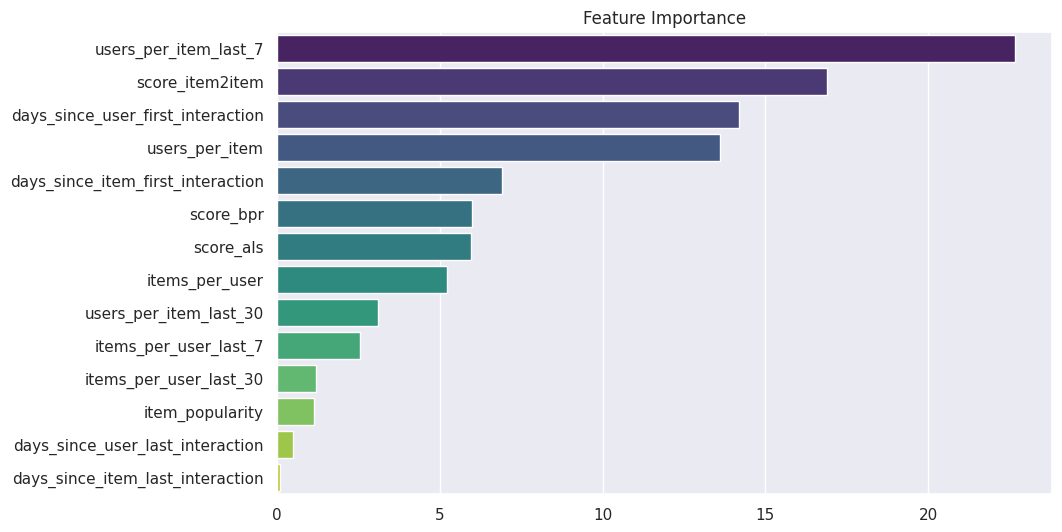

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values(), y=importances.keys(), palette="viridis")
plt.title('Feature Importance')
plt.show()

1. Top 4 most important features are almost all not even connected to the scores from base models:
- item popularity at the last 7 days
- days since the first activity of the user
- overall item popularity

2. Base models scores have a medium importance overall, except for the item2item score which has a high importance.

3. The following features were the least important:
- days since the last activity of the user
- days since the last time the track was played by a new user

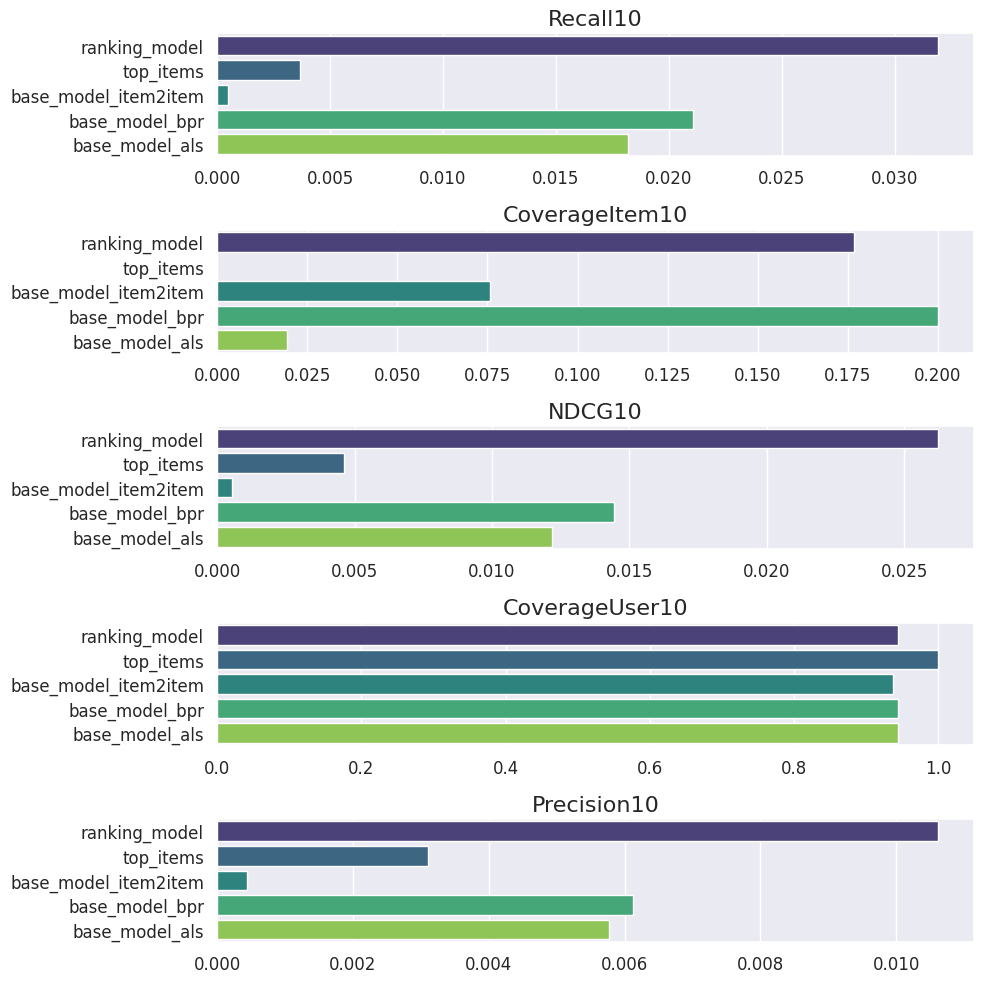

In [11]:
metrics = list(df.columns[1:])

fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 2 * len(metrics)))

if len(metrics) == 1:
    axes = [axes]

# Iterate over metrics and create a horizontal bar plot for each
for ax, metric in zip(axes, metrics):
    sns.barplot(x=metric, y='Model', data=df, ax=ax, palette="viridis")
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    ax.set_title(metric, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

In [12]:
df

,Model,Recall10,CoverageItem10,NDCG10,CoverageUser10,Precision10
0,ranking_model,0.031923,0.176669,0.026229,0.943874,0.010613
1,top_items,0.003685,0.000023,0.004624,1.000000,0.003107
2,base_model_item2item,0.000494,0.075743,0.000552,0.938064,0.000432
3,base_model_bpr,0.021092,0.200031,0.014425,0.943874,0.006120
4,base_model_als,0.018210,0.019404,0.012176,0.943874,0.005765


Ensemble ranking model significantly improves the performance of the recommendation system comparing to base models achieving
- `Precision@10`: 1.1% (5% - 20% for good models)
- `Recall@10`: 3.2% (1% - 10% for good models)
- `NDCG@10`: 2.6% (10% - 50% for good models)

while preserving a high rate of the coverage metrics:
- `CoverageItem@10`: 17.7%
- `CoverageUser@10`: 94.4%

`Novelty` metric is equal to 1 by default since only new items are recommended by all models except for model that suggests popular items - in this case the `Novelty` is surely less than 1.

It is clear, that the quality of the recommendations is not that great according to `Precision@10` - the model is not good enough at recommending relevant items to users, although it is not bad at detecting relevant items according to `Recall@10`.
To be fair, almost all users were considered - some of them might have very small number of interactions or very big number of interactions - such users might decrease the quality of the recommendations. As for items, it might be better to increase the cut-off value for the number of interactions so that more unpopular items are removed


Speaking of the item-popularity based recommendations, their quality is not that low - item2item model provided even poorer results, though the corresponding feature importance is very high


All in all, the following steps can be made to improve the quality of the recommendations:
- increase the cut-off value for the number of interactions per item so that more unpopular items are removed
- consider a cut-off value for the number of interactions per user so that users with low activity are removed
- consider tuning base models and the ensemble ranking model
- consider more user and item features for the ensemble ranking model
- consider more base models